In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.initializers import glorot_uniform
# from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from dataset import create_image_path_tripless_ds, preprocess_image
from Resnet50 import ResNet50

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
IMG_SIZE = 96

In [ ]:
@tf.keras.saving.register_keras_serializable()
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.math.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.math.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

In [ ]:
from tensorflow.keras.models import Model

res50 = ResNet50((IMG_SIZE,IMG_SIZE, 3), 2)

embedding = Sequential([
    Model(inputs=res50.input, outputs=res50.layers[-6].output, name='res50_extractor'),
    layers.Dense(512, name='fc_rd1'),
    layers.BatchNormalization(name= 'fc_db_rd1'),
    layers.Dense(128, name='fc_rd2'),
    layers.Normalization(name='fc_db_rd2'),
])
embedding.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 res50_extractor (Functiona  (None, 8192)              23587712  
 l)                                                              
                                                                 
 fc_rd1 (Dense)              (None, 512)               4194816   
                                                                 
 fc_db_rd1 (BatchNormalizat  (None, 512)               2048      
 ion)                                                            
                                                                 
 fc_rd2 (Dense)              (None, 128)               65664     
                                                                 
 fc_db_rd2 (Normalization)   (None, 128)               257       
                                                                 
Total params: 27850497 (106.24 MB)
Trainable params: 277

In [ ]:
anchor_input = layers.Input(shape=(IMG_SIZE,IMG_SIZE,3), name='anchor_input')
positive_input = layers.Input(shape=(IMG_SIZE,IMG_SIZE,3), name='positive_input')
negative_input = layers.Input(shape=(IMG_SIZE,IMG_SIZE,3), name='negative_input')


d_layer = DistanceLayer(name='d_distance')
distances = d_layer(embedding(anchor_input), embedding(positive_input), embedding(negative_input))


siamese_model = Model(inputs=[anchor_input, positive_input, negative_input], outputs=distances)

In [ ]:
@tf.keras.saving.register_keras_serializable()
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "siamese_network":self.siamese_network, "margin": self.margin}
    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

In [ ]:
model = SiameseModel(siamese_model, margin=0.2)
model.build([(None, IMG_SIZE,IMG_SIZE,3), (None, IMG_SIZE,IMG_SIZE,3), (None, IMG_SIZE,IMG_SIZE,3)])
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))
model.load_weights('/content/drive/MyDrive/demo/checkpoint/checkpoint1')


Model: "siamese_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          ((None,),                 27850497  
                              (None,))                           
                                                                 
Total params: 27850499 (106.24 MB)
Trainable params: 27796096 (106.03 MB)
Non-trainable params: 54403 (212.52 KB)
_________________________________________________________________


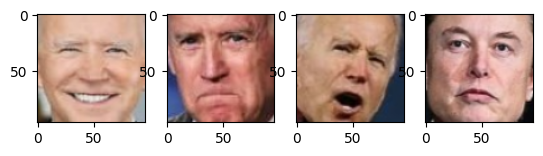

1/1 [==============================] - 0s 175ms/step
(array([1.3971059], dtype=float32), array([0.5343932], dtype=float32))
1/1 [==============================] - 0s 156ms/step
(array([0.88829195], dtype=float32), array([0.5343932], dtype=float32))


In [ ]:
img_a = preprocess_image('joe1.jpg',(IMG_SIZE, IMG_SIZE))
img_b = preprocess_image('joe2.jpg',(IMG_SIZE, IMG_SIZE))
img_c = preprocess_image('joe_crop3.jpg',(IMG_SIZE, IMG_SIZE))
img_d = preprocess_image('elon1.jpg',(IMG_SIZE, IMG_SIZE))

i_a = np.expand_dims(img_a, axis=0)
i_b = np.expand_dims(img_b, axis=0)
i_c = np.expand_dims(img_c, axis=0)
i_d = np.expand_dims(img_d, axis=0)

plt.subplot(1,4,1)
plt.imshow(img_a)
plt.subplot(1,4,2)
plt.imshow(img_b)
plt.subplot(1,4,3)
plt.imshow(img_c)
plt.subplot(1,4,4)
plt.imshow(img_d)
plt.show()

# for i in [i_a, i_b, i_c, i_d]:
#   for j in [i_a, i_b, i_c, i_d]:
#     if(model.predict([i, j]) > 0.51):
#       print(f'same')
#     else:
#       print(f'different')
print(model.predict([i_a, i_b, i_c]))
print(model.predict([i_a, i_d, i_c]))